### Tool for work with cub files

In [1]:
#------------------------------------------------------------------------------
# Module: cubetools
#------------------------------------------------------------------------------
#
# Description:
# Module to work with Gaussian cube format files
# (see http://paulbourke.net/dataformats/cube/)
#
#------------------------------------------------------------------------------
#
# What does it do:
# * Read/write cube files to/from numpy arrays (dtype=float*)
# * Read/write pairse of cube files to/from numpy arrays (dtype=complex*)
# * Provides a CubeFile object, to be used when cubefiles with 
#   constant and static data is required. It simulates the readline method
#   of a file object with a cube file opened, without creating a file
#
#------------------------------------------------------------------------------
#
# Dependency: numpy
#
#------------------------------------------------------------------------------
#
# Author: P. R. Vaidyanathan (aditya95sriram <at> gmail <dot> com)
# Date: 25th June 2017
#
#------------------------------------------------------------------------------
#
# MIT License
# 
# Copyright (c) 2019 P. R. Vaidyanathan
# 
# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:
# 
# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.
# 
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
# SOFTWARE.
#
#------------------------------------------------------------------------------

import numpy as np

if __name__ == '__main__':
    DEBUGMODE = True
else:
    DEBUGMODE = False

def _debug(*args):
    global DEBUGMODE
    if DEBUGMODE:
        print (" ".join(map(str, args)))

class CubeFile(object):
    """
    Object which mimics a cube file opened as a file object 
    by returning output in the correct format, matching the 
    metadata of the source cube file and replacing volumetric
    data with static data provided as arg to the constructor. 
    Doesn't copy atoms metadata, retains number of atoms, but
    returns dummy atoms
    Mimics file object's readline method.
    
    params:
        srcname: source file to copy metadata from
        const: numeric value to return instead of volumetric data
        
    returns: CubeFile object
    """

    def __init__(self, srcname, const=1):
        self.cursor = 0 
        self.const = const
        self.src = src = open(srcname)
        src.readline(); src.readline(); # comments
        _debug(srcname)
        self.lines = [" Cubefile created by cubetools.py\n", 
                      "  source: {0}\n".format(srcname)]
        self.lines.append(src.readline()) # read natm and origin
        self.natm = int(self.lines[-1].strip().split()[0])
        # read cube dim and vectors along 3 axes
        self.lines.extend(src.readline() for i in range(3))
        self.src.close()
        self.nx, self.ny, self.nz = [int(l.strip().split()[0]) for l in self.lines[3:6]]
        self.remvals = self.nz
        self.remrows = self.nx*self.ny
        for i in range(self.natm):
            self.lines.append("{0:^ 8d}".format(1) + "{0:< 12.6f}".format(0)*4 + '\n')

    def __del__(self):
        self.src.close()

    def readline(self):
        """ Mimic readline method of file object with cube file opened """
        try:
            retval = self.lines[self.cursor]
        except IndexError:
            if not self.remrows:
                return ""
            if self.remvals <= 6:
                nval = min(6,self.remvals)
                self.remrows -= 1
                self.remvals = self.nz 
            else:
                nval = 6
                self.remvals -= nval
            return " {0: .5E}".format(self.const)*nval + "\n"
        else:
            self.cursor += 1
            return retval
    
def _getline(cube):
    """
    Read a line from cube file where first field is an int 
    and the remaining fields are floats.
    
    params:
        cube: file object of the cube file
    
    returns: (int, list<float>)
    """
    l = cube.readline().strip().split()
    return int(l[0]), map(float, l[1:])

def _putline(*args):
    """
    Generate a line to be written to a cube file where 
    the first field is an int and the remaining fields are floats.
    
    params:
        *args: first arg is formatted as int and remaining as floats
    
    returns: formatted string to be written to file with trailing newline
    """
    s = "{0:^ 8d}".format(args[0])
    s += "".join("{0:< 12.6f}".format(arg) for arg in args[1:])
    return s + "\n"
    
def read_cube(fname):
    """ 
    Read cube file into numpy array
    
    params:
        fname: filename of cube file
        
    returns: (data: np.array, metadata: dict)
    """
    meta = {}
    with open(fname, 'r') as cube:
        cube.readline(); cube.readline()  # ignore comments
        natm, meta['org'] = _getline(cube)
        nx, meta['xvec'] = _getline(cube)
        ny, meta['yvec'] = _getline(cube)
        nz, meta['zvec'] = _getline(cube)
        meta['atoms'] = [_getline(cube) for i in range(natm)]
        data = np.zeros((nx*ny*nz))
        idx = 0
        for line in cube:
            for val in line.strip().split():
                data[idx] = float(val)
                idx += 1
    data = np.reshape(data, (nx, ny, nz))
    return data, meta
    
def read_imcube(rfname, ifname = ""):
    """
    Convenience function to read in two cube files at once, 
    where one contains the real part and the other contains the 
    imag part. If only one filename given, other filename is inferred.
    
    params:
        rfname: filename of cube file of real part
        ifname: optional, filename of cube file of imag part
        
    returns: np.array (real part + j*imag part)
    """
    ifname = ifname or rfname.replace('real', 'imag')
    _debug("reading from files", rfname, "and", ifname)
    re, im = read_cube(rfname), read_cube(ifname)
    fin = np.zeros(re[0].shape, dtype='complex128')
    if re[1] != im[1]:
        _debug("warning: meta data mismatch, real part metadata retained")
    fin += re[0] 
    fin += 1j*im[0]
    return fin, re[1]

def write_cube(data, meta, fname):
    """
    Write volumetric data to cube file along
    
    params:
        data: volumetric data consisting real values
        meta: dict containing metadata with following keys
            atoms: list of atoms in the form (mass, [position])
            org: origin
            xvec,yvec,zvec: lattice vector basis
        fname: filename of cubefile (existing files overwritten)
    
    returns: None
    """
    with open(fname, "w") as cube:
        # first two lines are comments
        cube.write(" Cubefile created by cubetools.py\n  source: none\n")
        natm = len(meta['atoms'])
        nx, ny, nz = data.shape
        cube.write(_putline(natm, *meta['org'])) # 3rd line #atoms and origin
        cube.write(_putline(nx, *meta['xvec']))
        cube.write(_putline(ny, *meta['yvec']))
        cube.write(_putline(nz, *meta['zvec']))
        for atom_mass, atom_pos in meta['atoms']:
            cube.write(_putline(atom_mass, *atom_pos)) #skip the newline
        for i in range(nx):
            for j in range(ny):
                for k in range(nz):
                    if (i or j or k) and k%6==0:
                        cube.write("\n")
                    cube.write(" {0: .5E}".format(data[i,j,k]))
                    
def write_imcube(data, meta, rfname, ifname=""):
    """
    Convenience function to write two cube files from complex valued 
    volumetric data, one for the real part and one for the imaginary part.
    Data about atoms, origin and lattice vectors are kept same for both.
    If only one filename given, other filename is inferred.
    
    params: 
        data: volumetric data consisting complex values
        meta: dict containing metadata with following keys
            atoms: list of atoms in the form (mass, [position])
            org: origin
            xvec,yvec,zvec: lattice vector basis
        rfname: filename of cube file containing real part
        ifname: optional, filename of cube file containing imag part
        
    returns: None
    """
    ifname = ifname or rfname.replace('real', 'imag')
    _debug("writing data to files", rfname, "and", ifname)
    write_cube(data.real, meta, rfname)
    write_cube(data.imag, meta, ifname)

### Take a look at some data

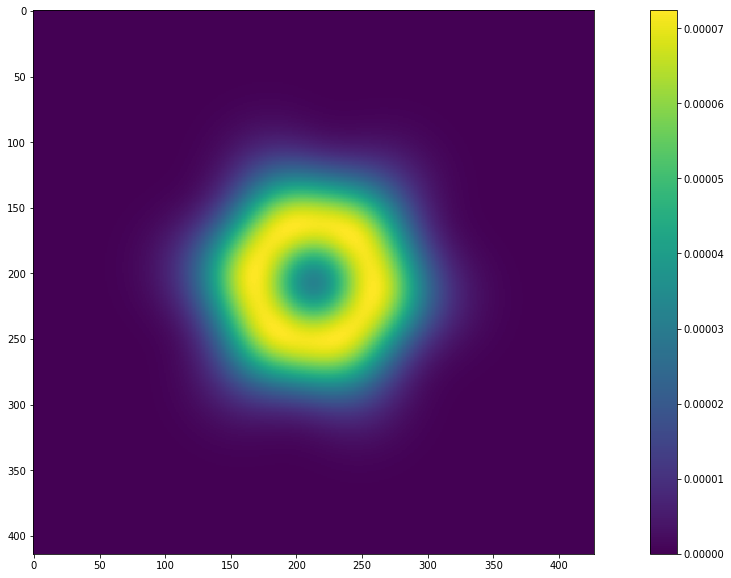

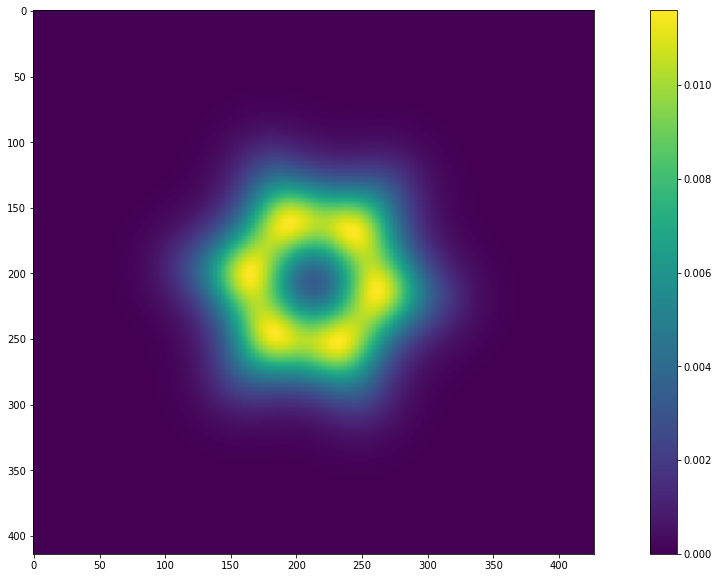

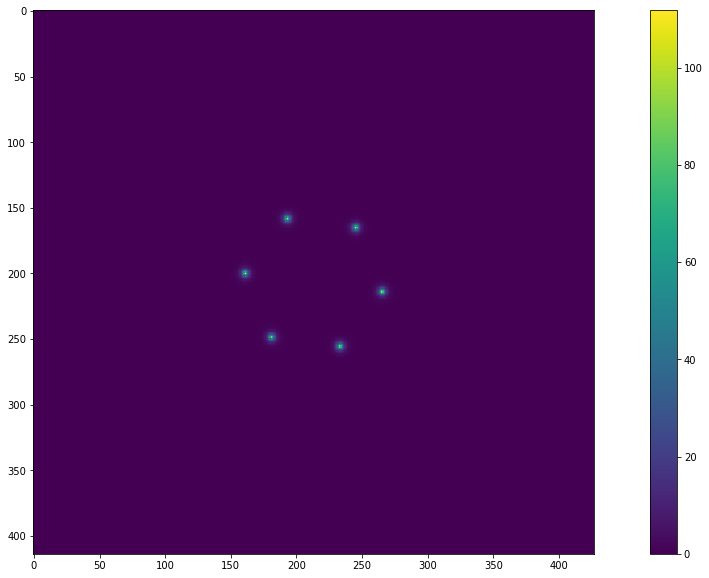

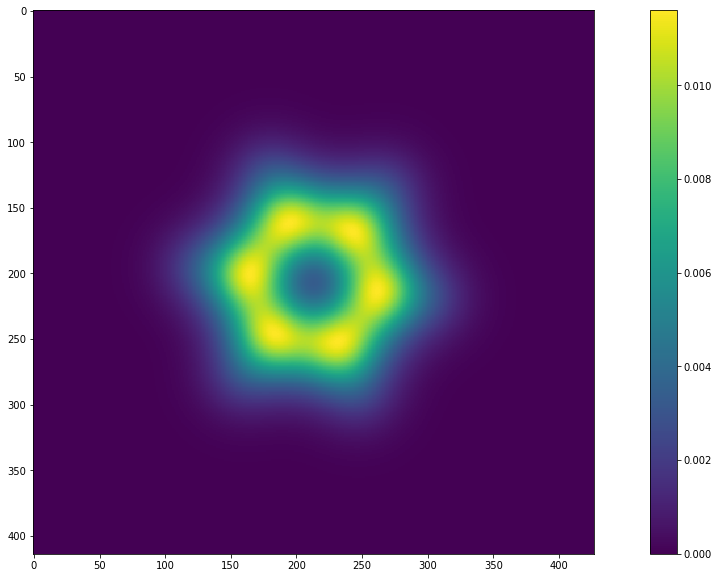

In [3]:
data = read_cube("cubs/Benzene.fchkdensity.cub")[0]
import matplotlib.pyplot as plt
for i in range(20,200, 50):
    fig = plt.figure(figsize=(20, 10))
    plt.imshow(data[:,:,i])
    plt.colorbar(orientation='vertical')
    plt.show()

### Functions for process cub to np.arrays - x & y

In [4]:
import pylibxc
def calc(rho):
    func = pylibxc.LibXCFunctional("gga_c_pbe", "unpolarized")
    func2 = pylibxc.LibXCFunctional("gga_x_pbe", "unpolarized")
    grad = np.gradient(rho, 0.05)
    sigma = np.sqrt(grad[0]**2+grad[1]**2+grad[2]**2)
    corr = func.compute({"rho":rho, "sigma":sigma})['zk']
    exc = func2.compute({"rho":rho, "sigma":sigma})['zk']
    return corr+exc


def cub_to_sample(name):
    data = read_cube(name)
    X = data[0]
    Y = calc(X).reshape(X.shape)
    return(X,Y)

# Test
point = cub_to_sample("cubs/Benzene.fchkdensity.cub")
print(point[0].shape,point[0].shape)

(414, 427, 241) (414, 427, 241)


### Create list of density and energy density maps

In [5]:
import glob
from ipywidgets import IntProgress
from IPython.display import display

files = glob.glob("cubs/*.cub")

b = IntProgress(min=0,max=len(files))
display(b)


X = []
Y = []
for file in files:
    b.value+=1
    print(file, b.value)
    sample = cub_to_sample(file)
    X.append(sample[0])
    Y.append(sample[1])

IntProgress(value=0, max=13)

cubs/Ethanol.fchkdensity.cub 1
cubs/Glycerol.fchkdensity.cub 2
cubs/D-Leucine.fchkdensity.cub 3
cubs/D-Histidine.fchkdensity.cub 4
cubs/Ethane.fchkdensity.cub 5
cubs/Toluene.fchkdensity.cub 6
cubs/Anthracene.fchkdensity.cub 7
cubs/Methane.fchkdensity.cub 8
cubs/Aniline.fchkdensity.cub 9
cubs/D-Cysteine.fchkdensity.cub 10
cubs/Caffeine.fchkdensity.cub 11
cubs/D-Alanine.fchkdensity.cub 12
cubs/Benzene.fchkdensity.cub 13


### Convert list to dataset with equal maps size NxNxN

In [6]:
N=5
K=3
# sample(rho and energy arrays with equal size) to lists of maps NxNxN
def sample_to_maps(rho, e):
    xs = []
    ys = []
    assert(rho.shape==e.shape)
    for i in range(0, e.shape[0], K):
        for j in range(0, e.shape[1], K):
            for k in range(0, e.shape[2], K):
                x = rho[i:i+N, j:j+N, k:k+N]
                y = e[i:i+N, j:j+N, k:k+N]
                if x.shape!=(N,N,N): continue
                xs.append(x)
                ys.append(y)
    return xs, ys

# even goes to train
X_train = X[::2]
Y_train = Y[::2]

# odd goes to test
X_test = X[1::2]
Y_test = Y[1::2]



b = IntProgress(min=0,max=len(Y))
display(b)

# iterate over list of train samples creating dataset = (xs,ys)
xs_train = []
ys_train = []
for (rho, e) in zip(X_train,Y_train):
    x,y = sample_to_maps(rho,e)
    xs_train+=x
    ys_train+=y
    b.value+=1
    

# iterate over list of test samples creating dataset = (xs,ys)
xs_test = []
ys_test = []
for (rho, e) in zip(X_test,Y_test):
    x,y = sample_to_maps(rho,e)
    xs_test+=x
    ys_test+=y
    b.value+=1


IntProgress(value=0, max=13)

In [9]:
# import gc
# del(X)
# del(Y)
# del(X_train)
# del(X_test)
# gc.collect()

X_train = np.array(xs_train)
Y_train = np.array(ys_train)

X_test = np.array(xs_test)
Y_test = np.array(ys_test)

In [10]:
print(f"""
TRAIN:
X: {X_train.shape}, Y: {Y_train.shape}
TEST:
X: {X_test.shape}, Y: {Y_test.shape}
""")


TRAIN:
X: (13721052, 5, 5, 5), Y: (13721052, 5, 5, 5)
TEST:
X: (12199994, 5, 5, 5), Y: (12199994, 5, 5, 5)



### Save dataset to compressed npz file

In [11]:
np.save("x_test", X_test)
np.save("y_test", Y_test)

np.save("x_train", X_train)
np.save("y_train", Y_train)

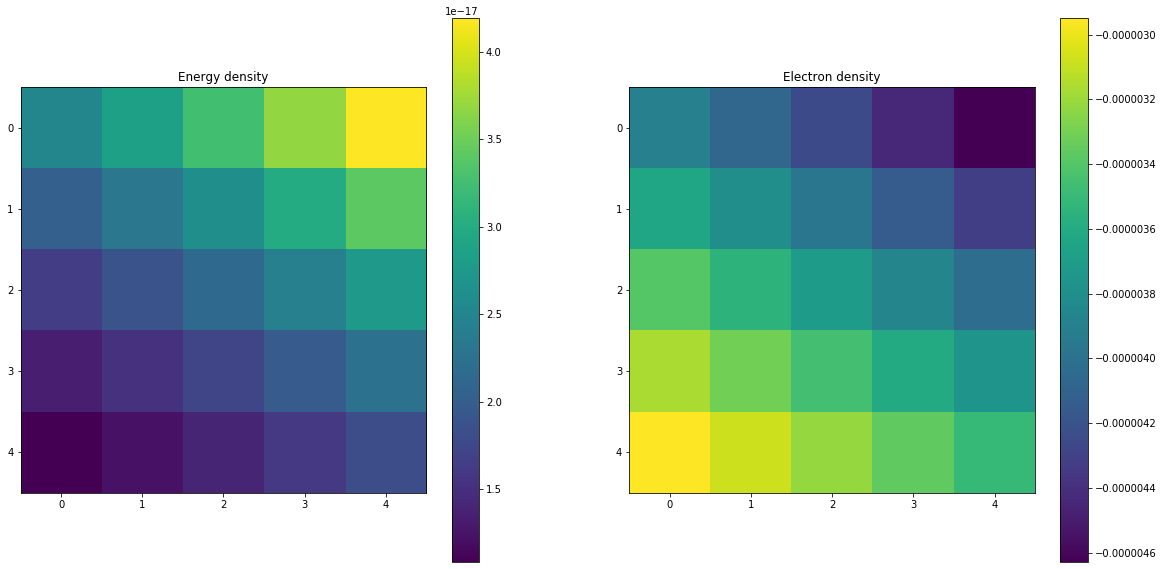

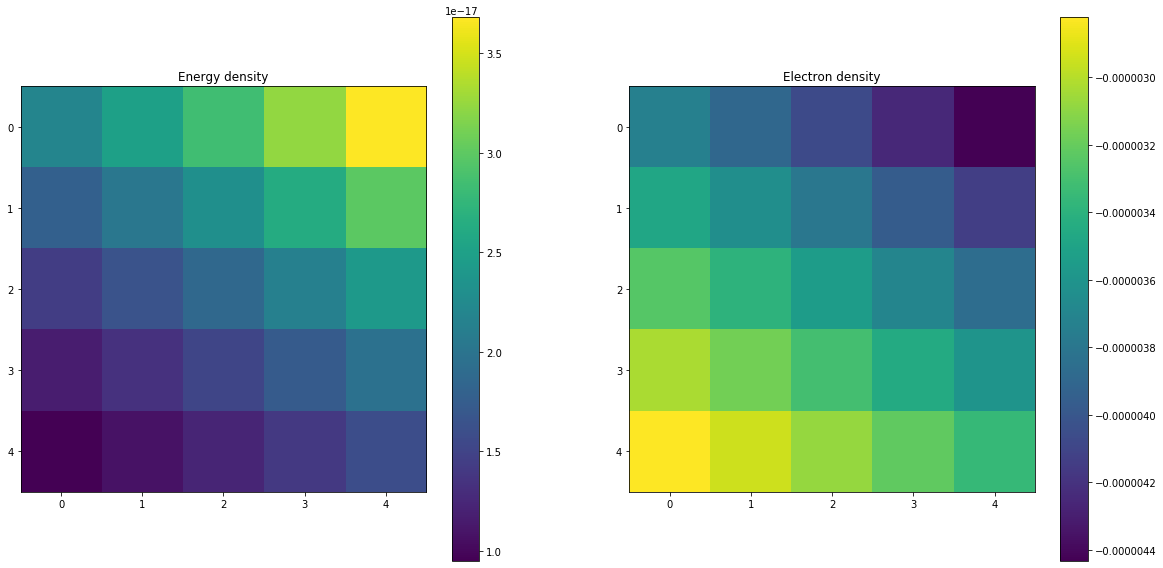

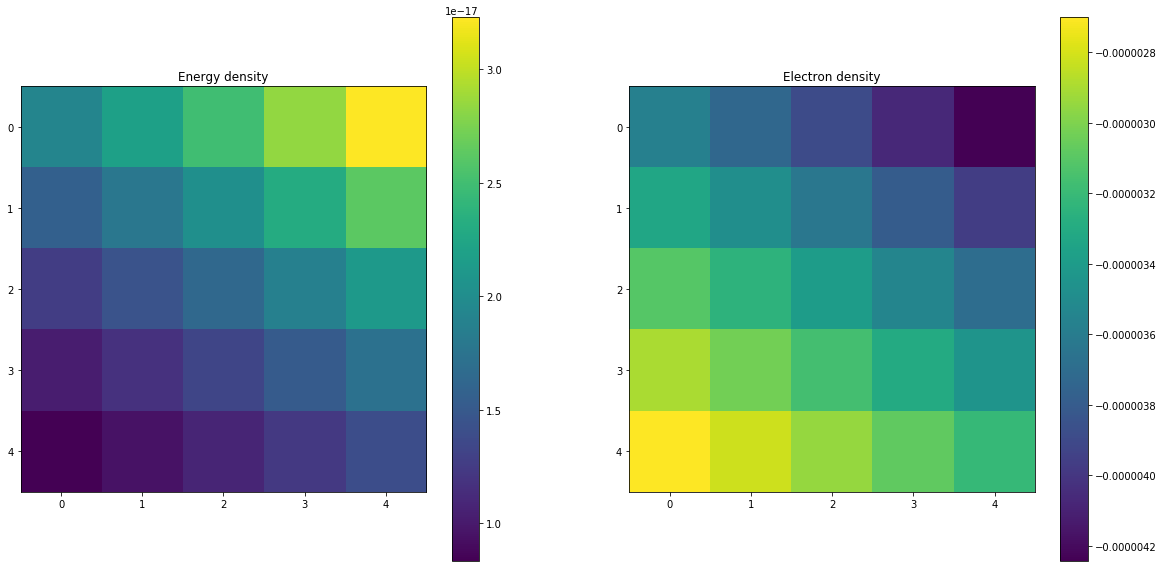

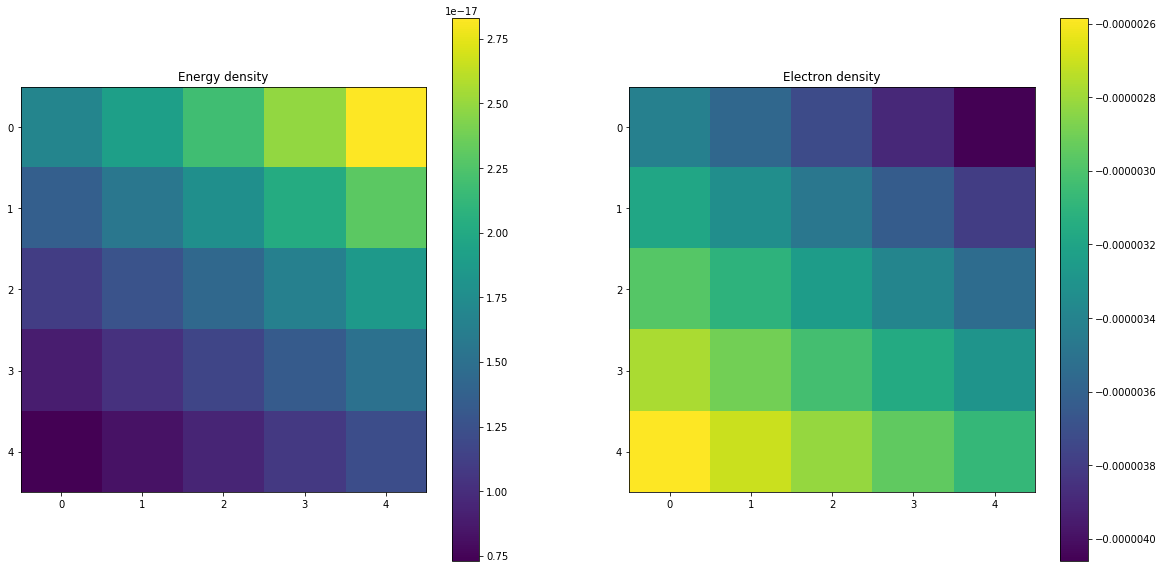

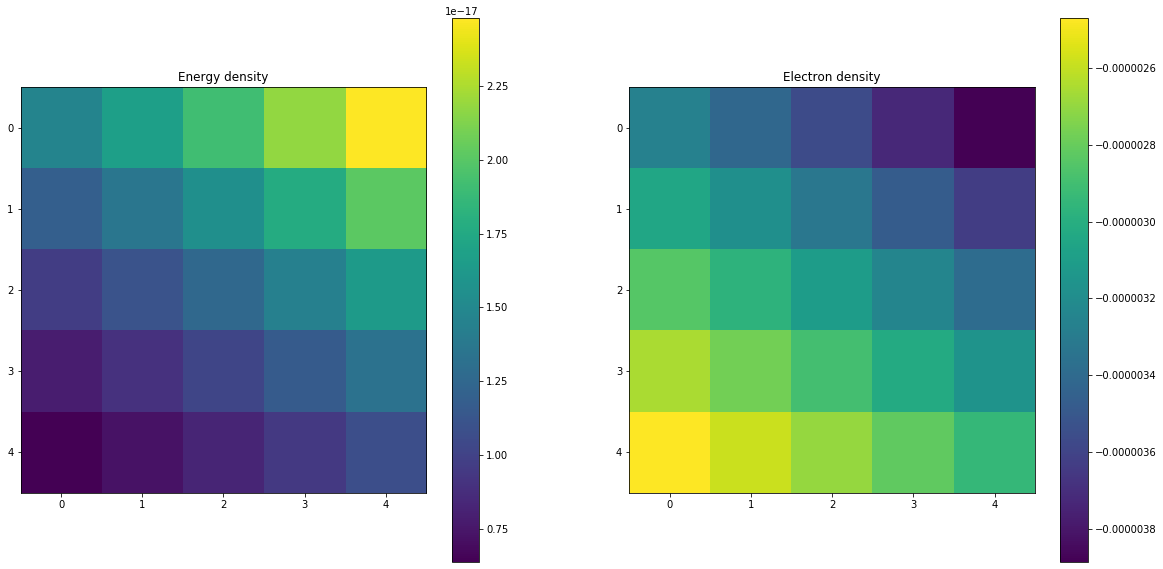

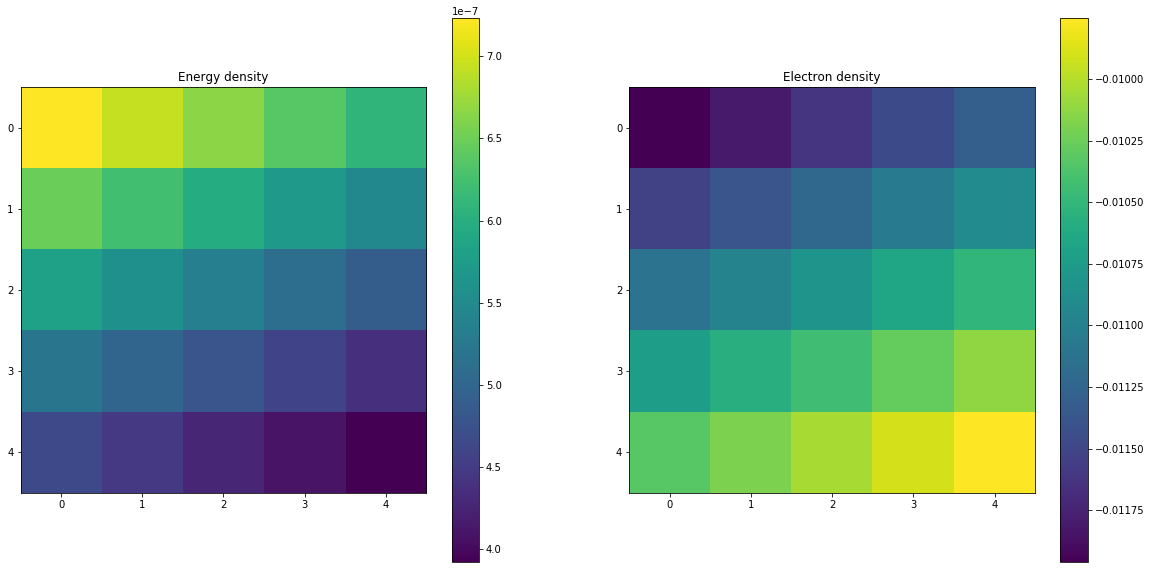

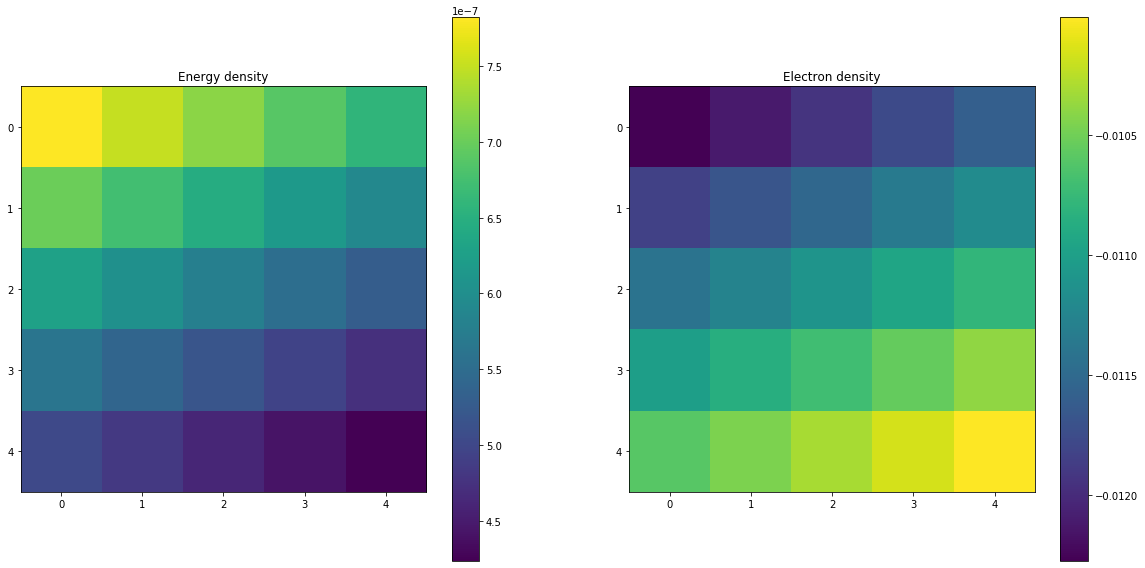

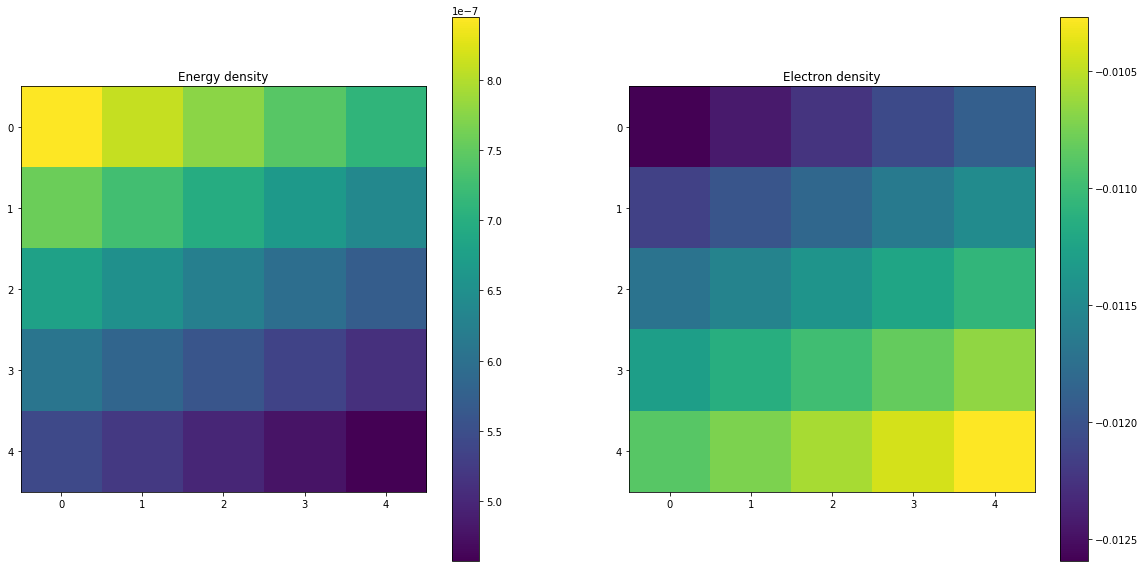

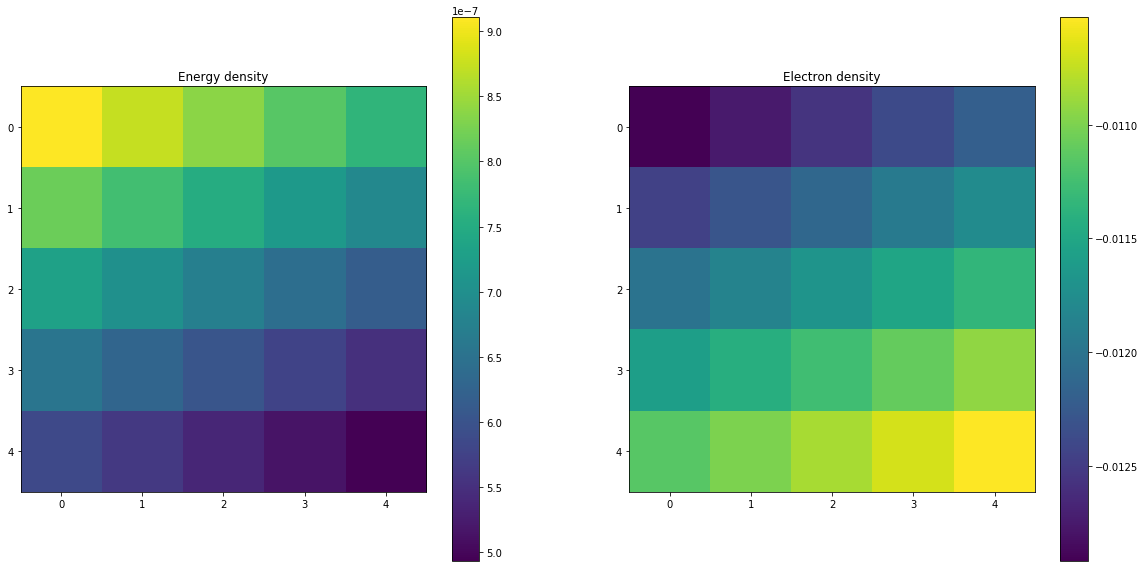

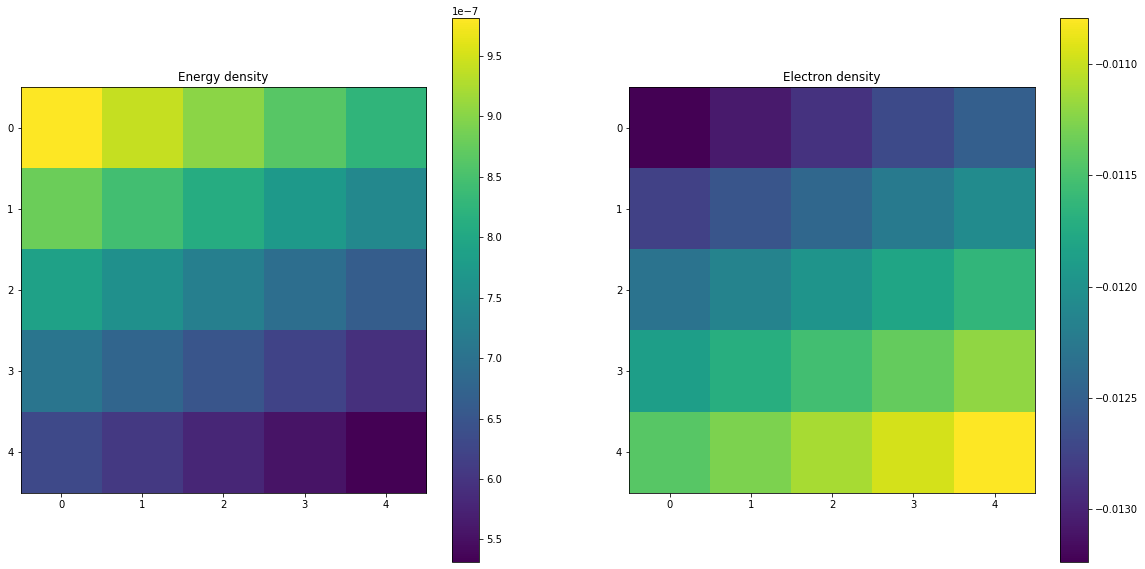

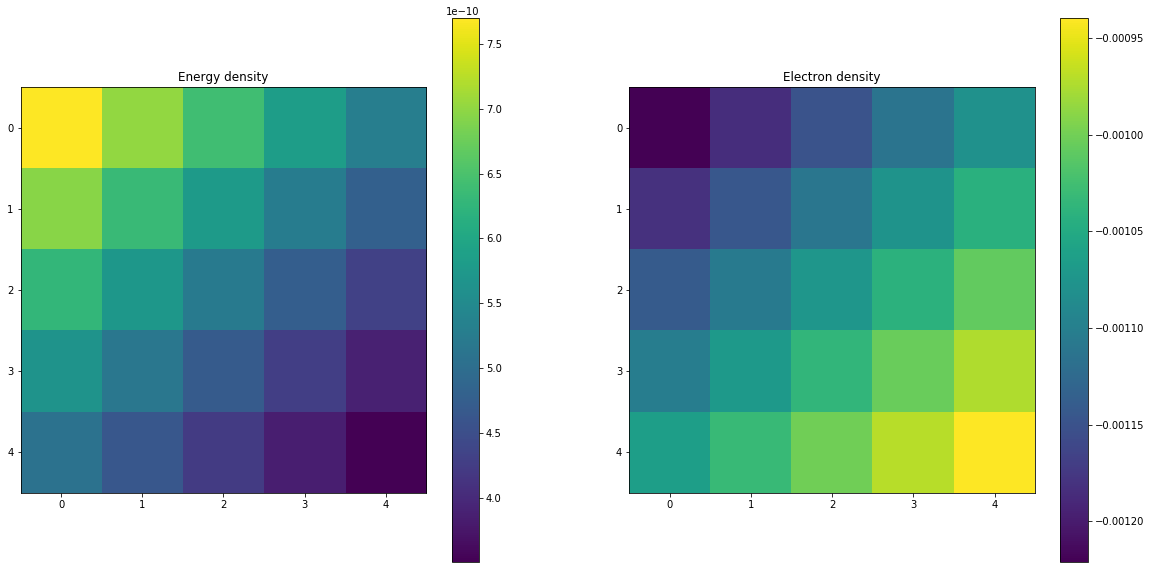

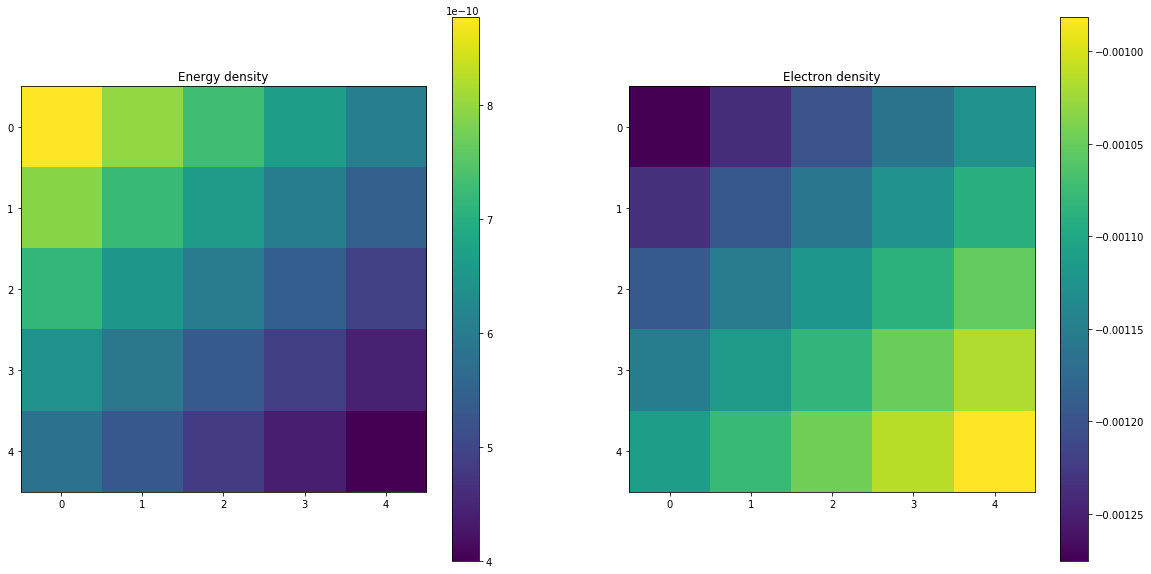

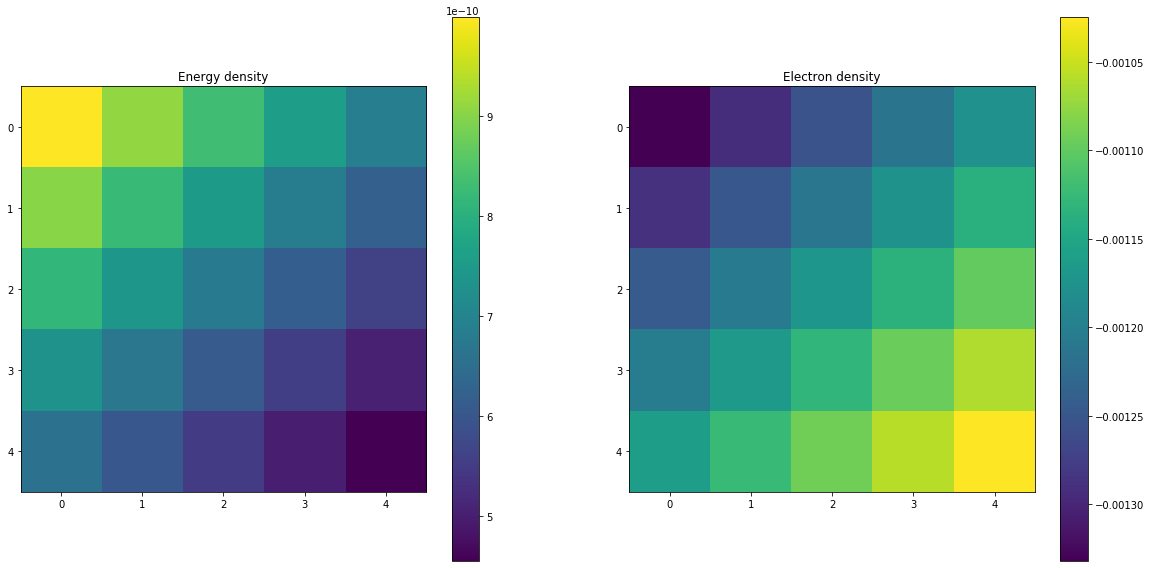

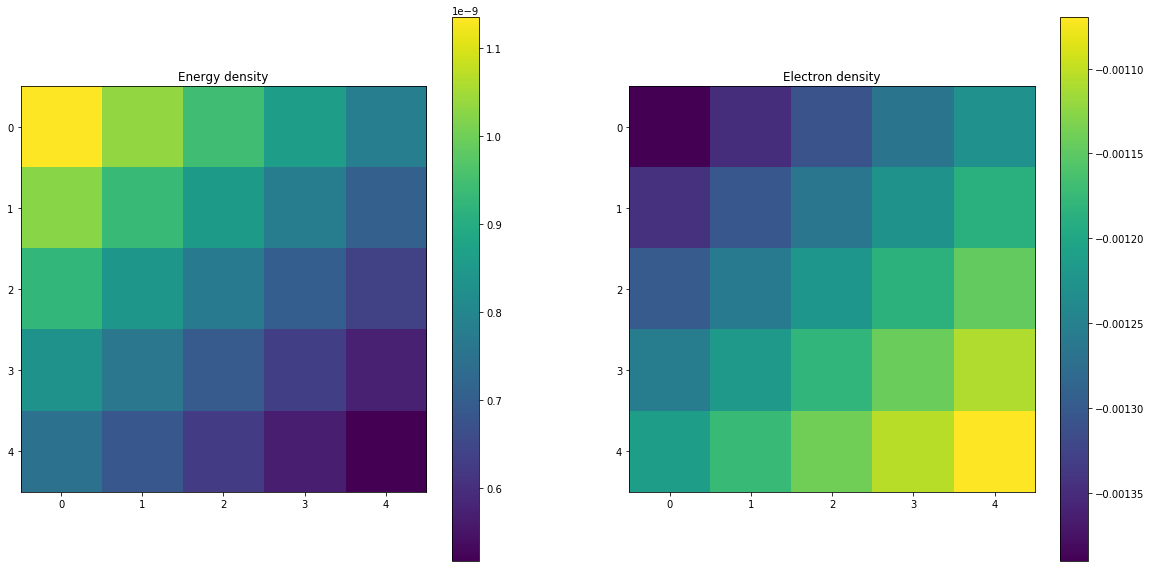

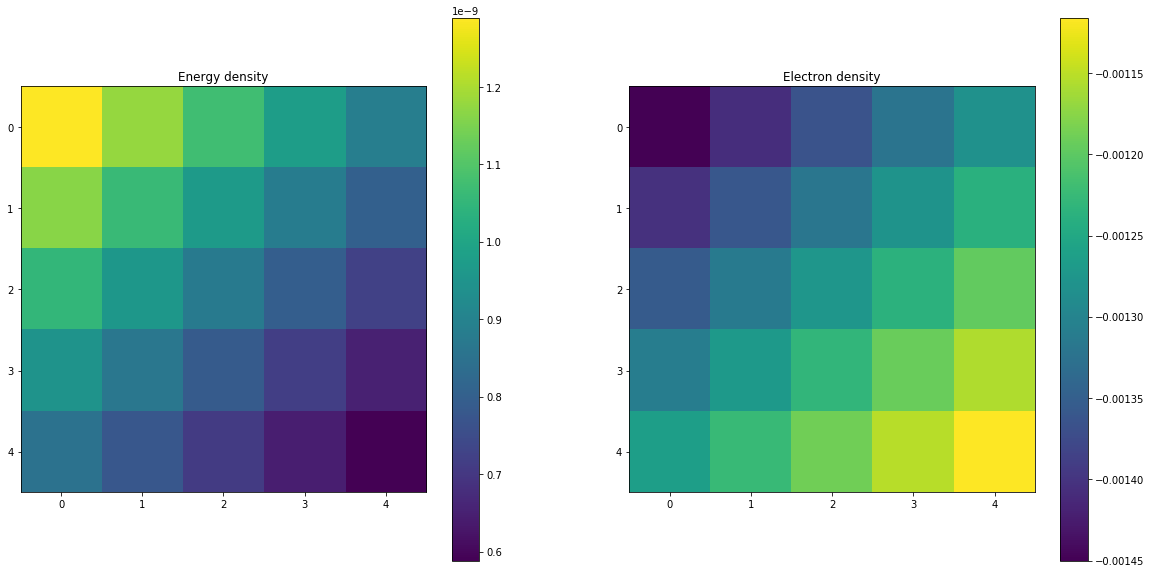

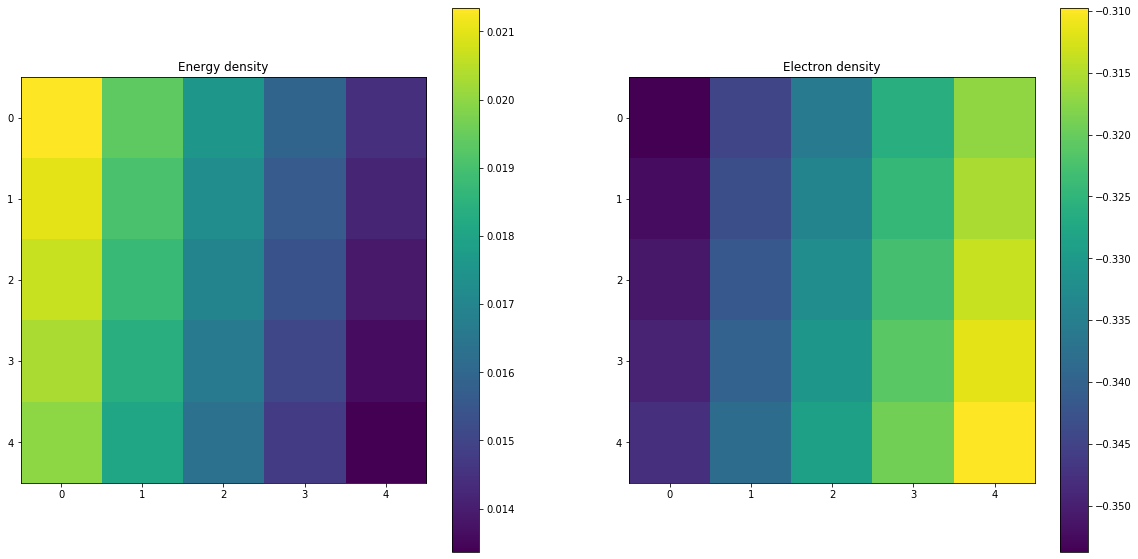

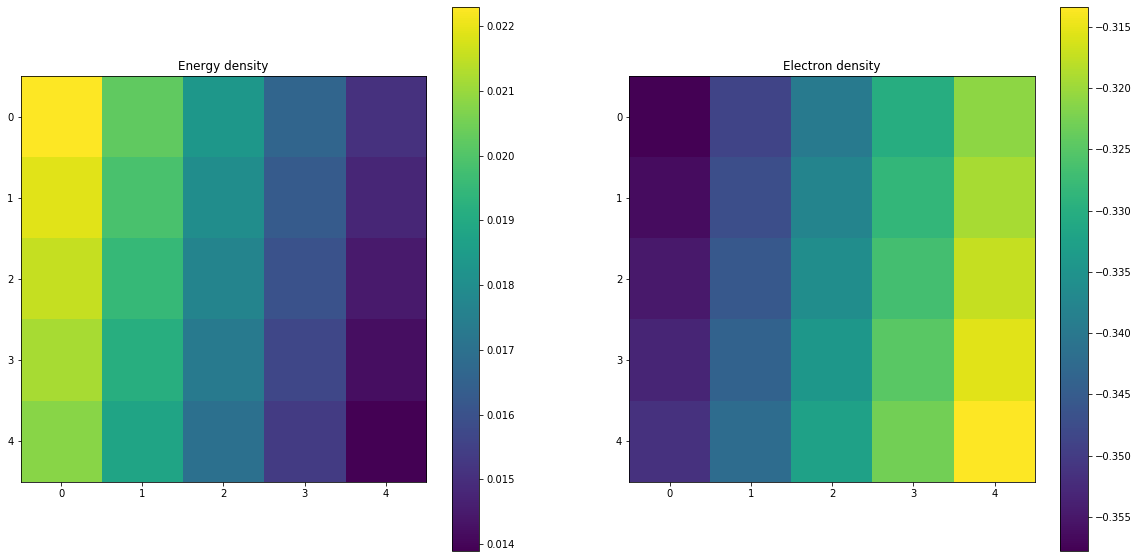

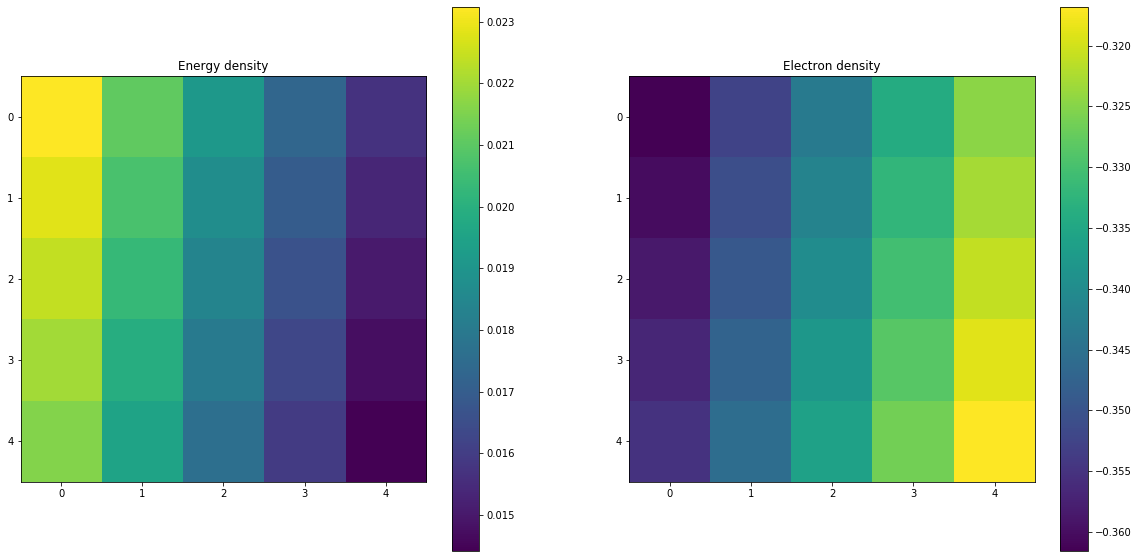

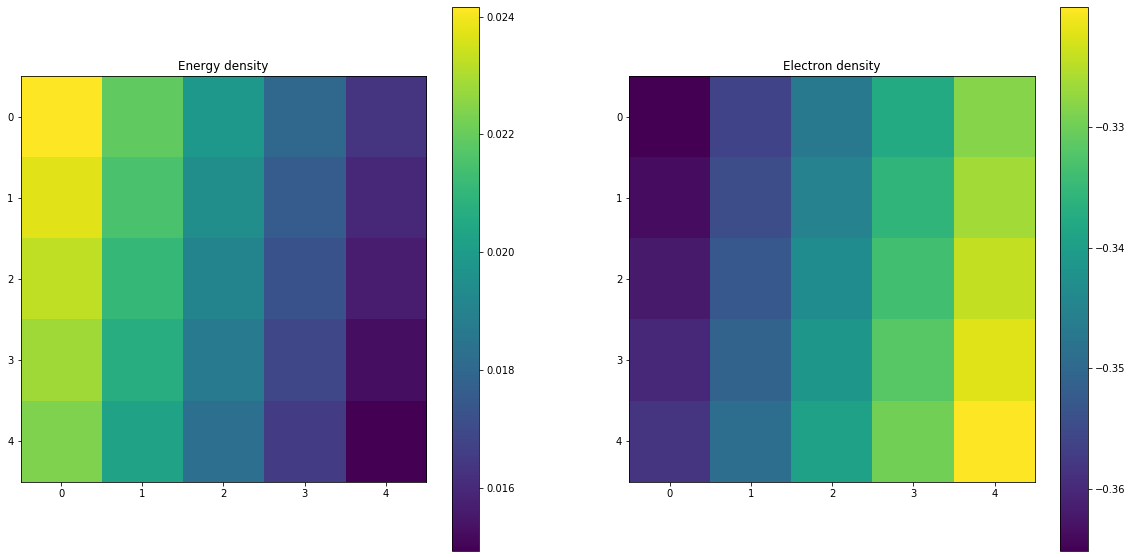

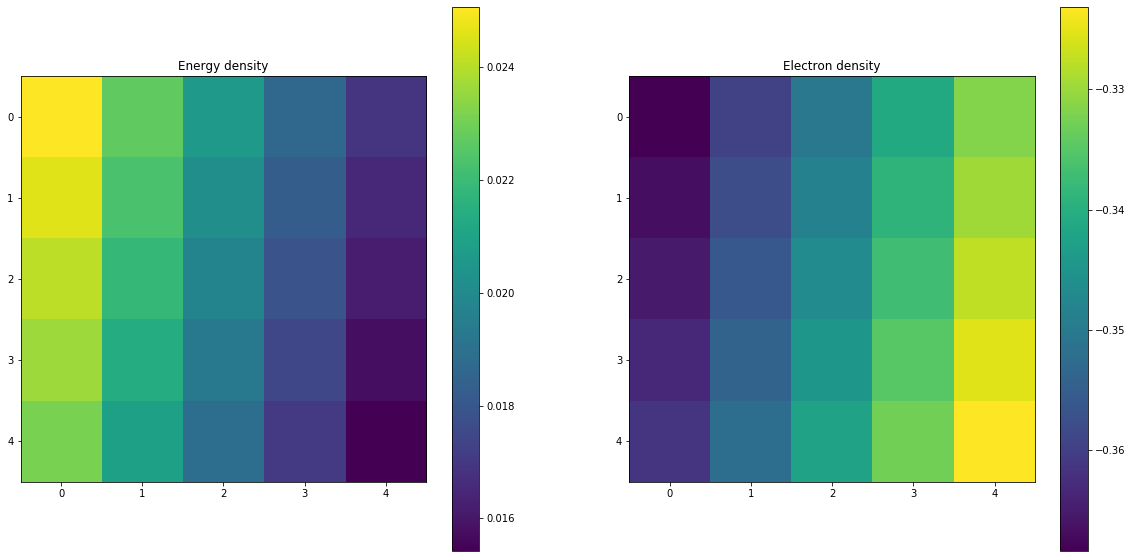

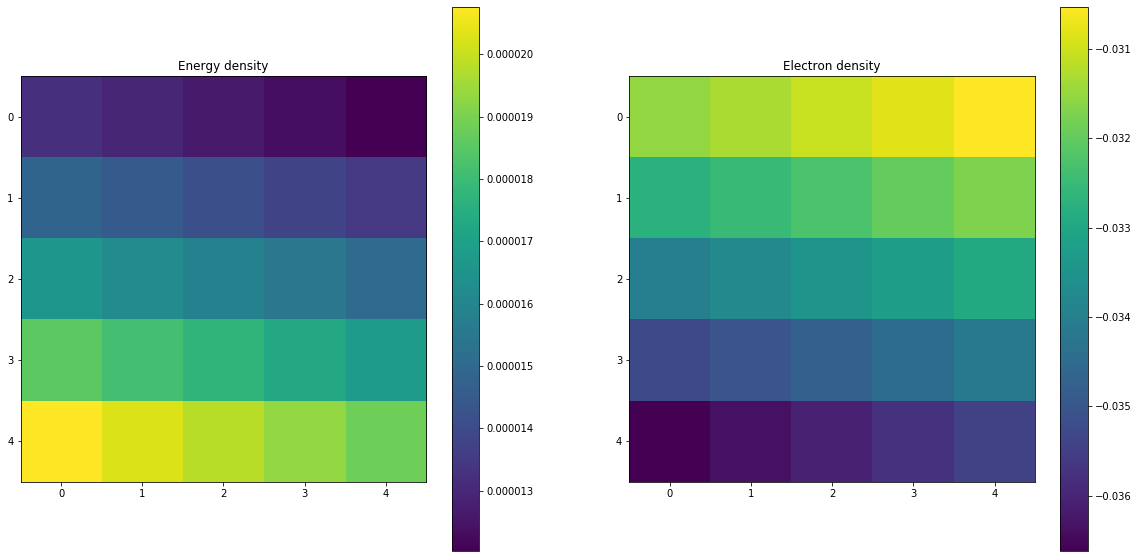

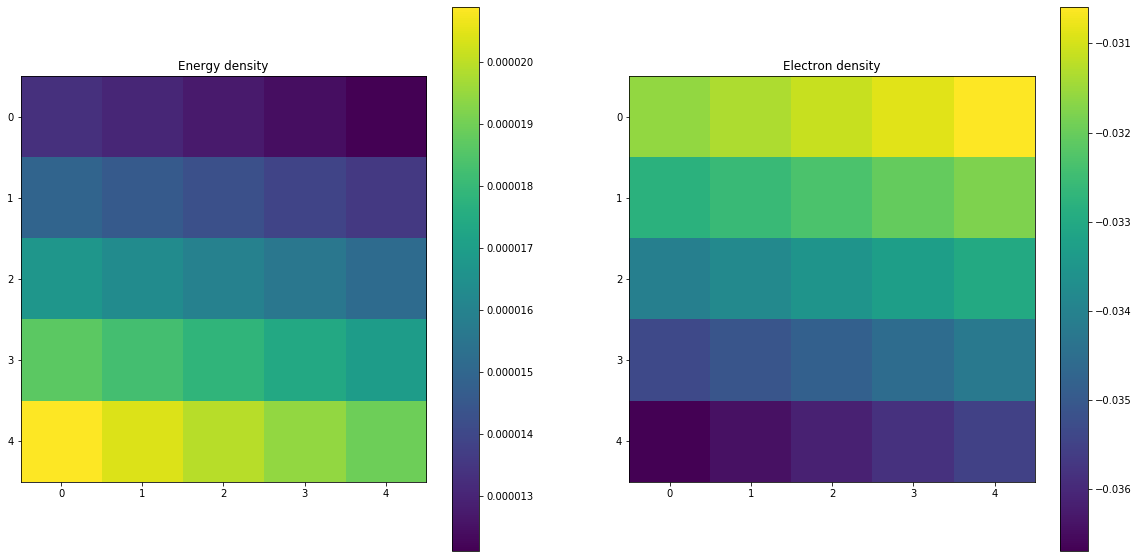

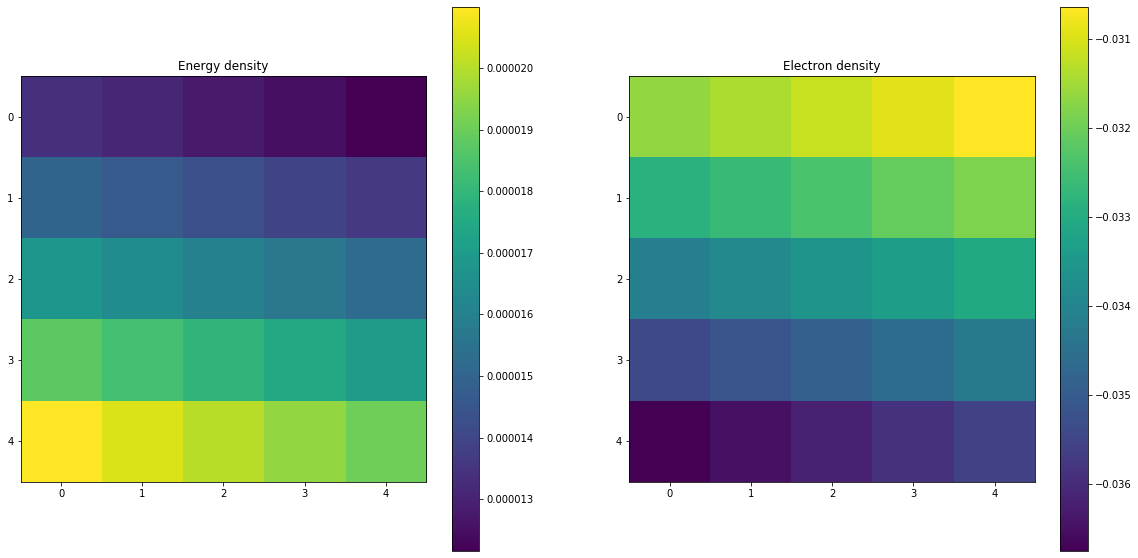

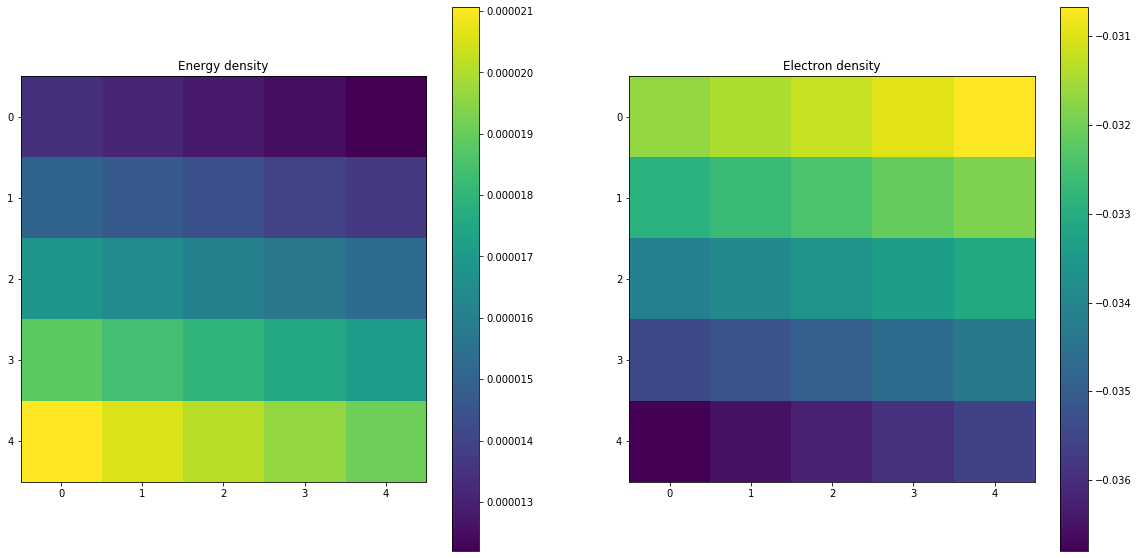

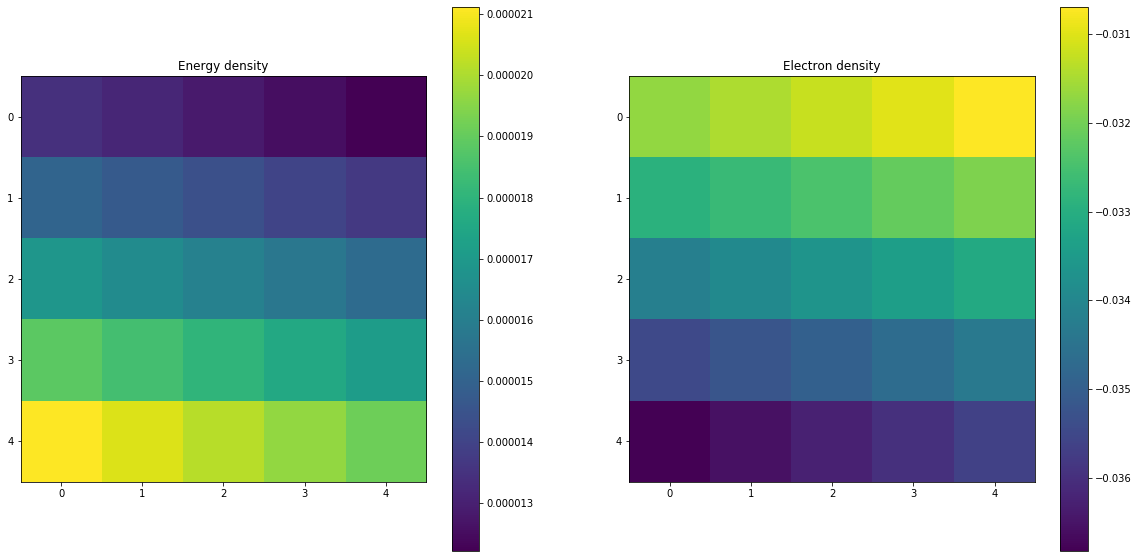

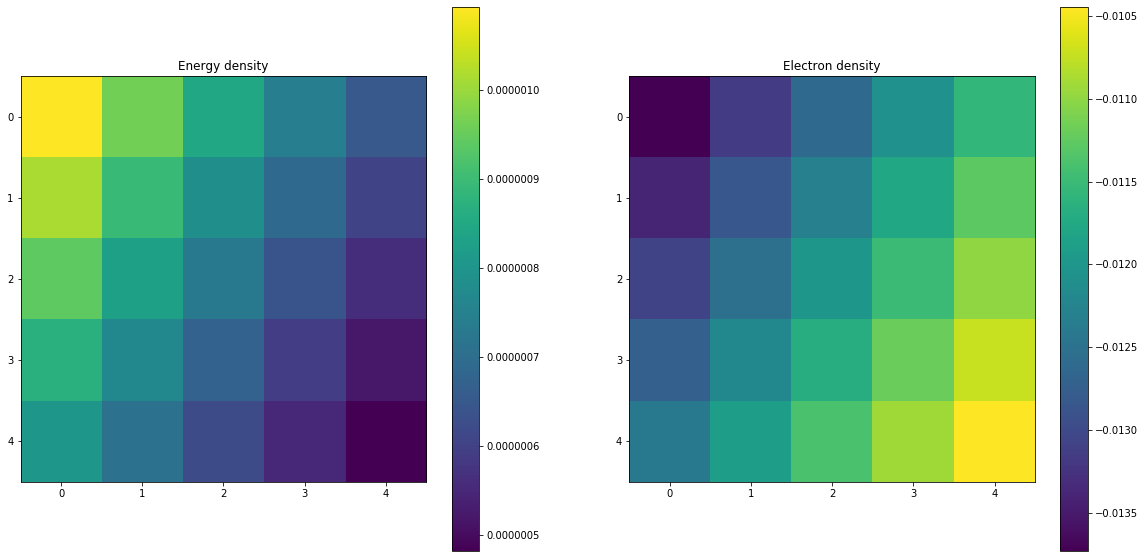

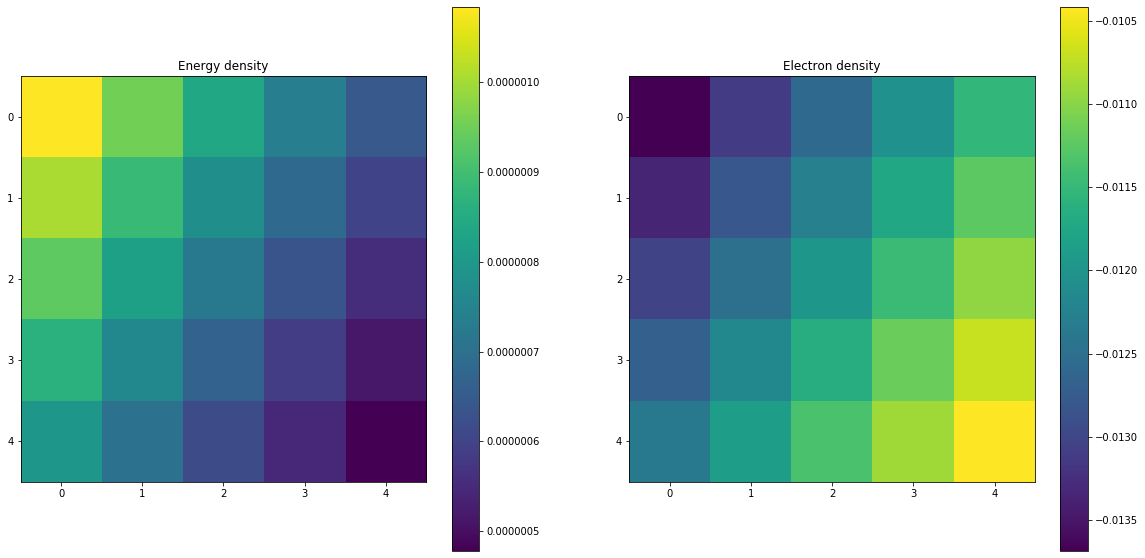

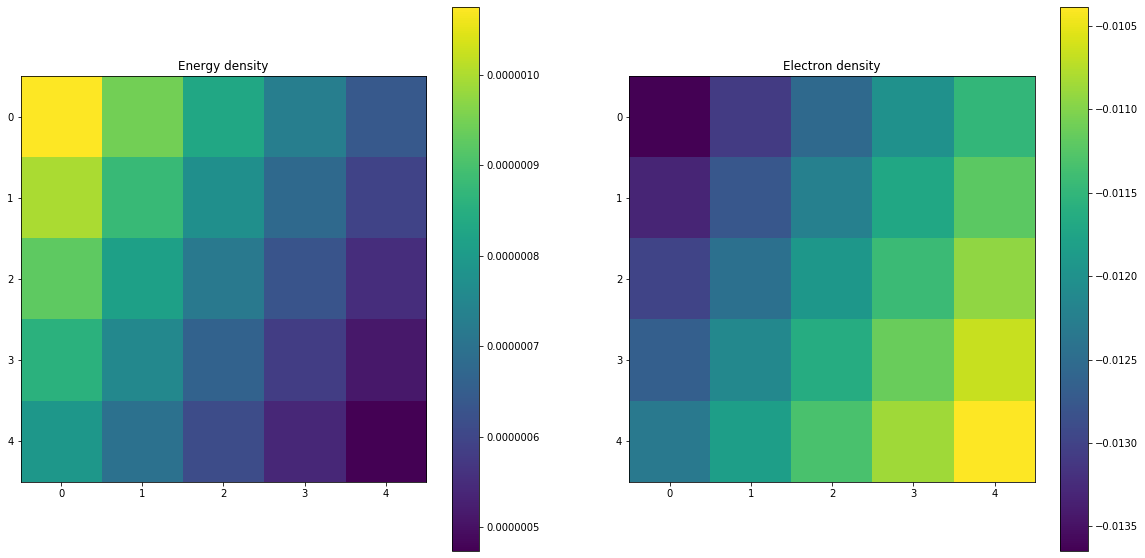

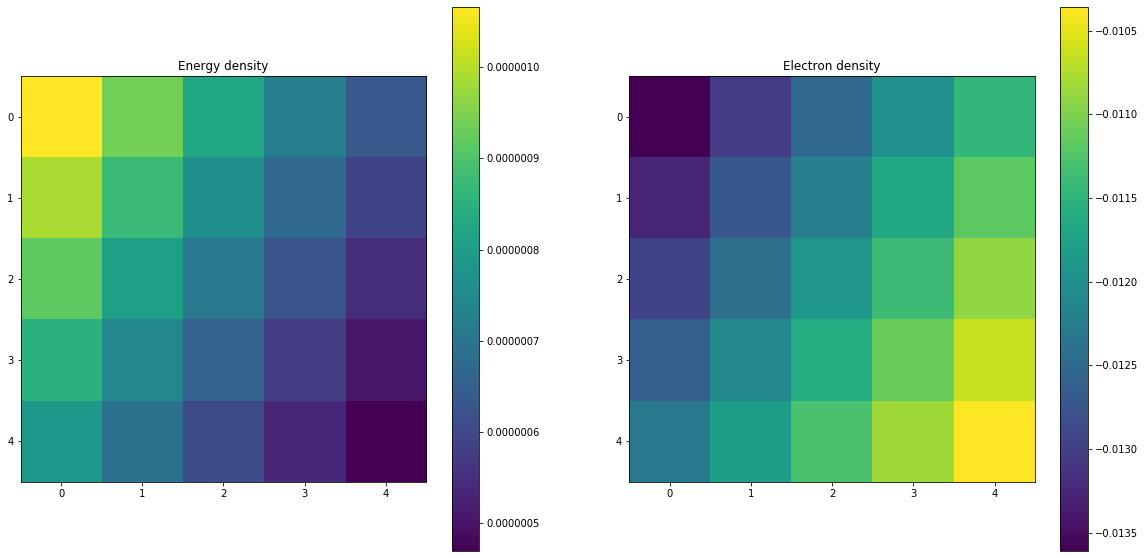

KeyboardInterrupt: 

In [19]:
import matplotlib.pyplot as plt
for i in np.random.randint(0, 13000000,10):
    X = X_train[i]
    Y = Y_train[i]
    for i in range(0,5):   
        fig = plt.figure(figsize=(20, 10))
        
        ax = fig.add_subplot(121)
        ax.set_title('Energy density')
        plt.imshow(X[i,:,:])
        ax.set_aspect('equal')
        plt.colorbar(orientation='vertical')

        ax = fig.add_subplot(122)
        ax.set_title('Electron density')
        plt.imshow(Y[i,:,:])
        ax.set_aspect('equal')
        plt.colorbar(orientation='vertical')
        plt.show()